In [ ]:
# Lam Hue Dung - MAMAIU18060
# Tran Thanh Dat - MAMAIU17036
# Tran Viet Hang - MAMAIU18079

In [ ]:
# Import Libraries
import time
start_time = time.time()

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import io
import requests
import pkg_resources
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.probability import FreqDist
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from collections import Counter
from wordcloud import WordCloud
import re
import string
from bs4 import BeautifulSoup
!pip install symspellpy
from symspellpy.symspellpy import SymSpell
!pip install autocorrect
from autocorrect import Speller

from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
from IPython.core import display as ICD

print('--- Executed in %.5s seconds ---' % (time.time() - start_time))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 2.6MB 7.6MB/s 
     |████████████████████████████████| 624kB 6.9MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.5.0-cp37-none-any.whl size=621854 sha256=27d07056f69636cfbca4bb68dcff7a5b7b3a9c13eeca9273aa8393b914d053ad
  Stored in directory: /root/.cache/pip/wheels/1f/71/da/4a15028d25fbd5fb97fb76c5f76f0ad86f0caa69394dd7cfa7
Successfully built autocorrect
--- Executed in 11.57 seconds ---


**1. Import - Preprocessing:**

In [ ]:
start_time = time.time()
url = 'https://raw.githubusercontent.com/QuanNguyenIU/Dataset/main/group9.csv'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), header = None)
df = df[[4, 16]]
df.rename({4: 'Title', 16: 'Description'}, axis = 'columns', inplace = True)
ICD.display(df)
print('--- Executed in %.5s seconds ---' % (time.time() - start_time))

,Title,Description
0,Nobody; OK to take it and work on it,user-ag mozilla/5 window window nt en-u rv gec...
1,Nelson Bolyard (seldom reads bugmail),creat attach detail server cert origin report ...
2,Nobody; OK to take it and work on it,user-ag mozilla/5 x11 linux i686 en-u rv gecko...
3,Nobody; OK to take it and work on it,notic problem site button search engin button ...
4,Nobody; OK to take it and work on it,drag bookmark bookmarks-menu folder folder los...
...,...,...
10294,Dave Townsend (:Mossop),extens instal pointer file directori point ext...
10295,Taras Glek (:taras),creat attach detail diff review replac quot en...
10296,Zack Weinberg (:zwol),creat attach detail testcas testcas crash trun...
10297,Aravind Gottipati [:aravind],backup khan-vm khan bug info khan khan khan mo...


--- Executed in 2.385 seconds ---


In [ ]:
# Remove Punctuations
PUNCT = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans(PUNCT, ' ' * len(PUNCT)))

def preprocessing_1(df):
    df['nonum'] = df['Description'].str.replace('\d+', '')
    df['nopun'] = df['nonum'].apply(lambda text: remove_punctuation(text))
    print('Preprocessing complete.')

In [ ]:
start_time = time.time()
preprocessing_1(df)
ICD.display(df)
print('--- Executed in %.5s seconds ---' % (time.time() - start_time))

Preprocessing complete.


,Title,Description,nonum,nopun
0,Nobody; OK to take it and work on it,user-ag mozilla/5 window window nt en-u rv gec...,user-ag mozilla/ window window nt en-u rv geck...,user ag mozilla window window nt en u rv geck...
1,Nelson Bolyard (seldom reads bugmail),creat attach detail server cert origin report ...,creat attach detail server cert origin report ...,creat attach detail server cert origin report ...
2,Nobody; OK to take it and work on it,user-ag mozilla/5 x11 linux i686 en-u rv gecko...,user-ag mozilla/ x linux i en-u rv gecko/ fire...,user ag mozilla x linux i en u rv gecko fire...
3,Nobody; OK to take it and work on it,notic problem site button search engin button ...,notic problem site button search engin button ...,notic problem site button search engin button ...
4,Nobody; OK to take it and work on it,drag bookmark bookmarks-menu folder folder los...,drag bookmark bookmarks-menu folder folder los...,drag bookmark bookmarks menu folder folder los...
...,...,...,...,...
10294,Dave Townsend (:Mossop),extens instal pointer file directori point ext...,extens instal pointer file directori point ext...,extens instal pointer file directori point ext...
10295,Taras Glek (:taras),creat attach detail diff review replac quot en...,creat attach detail diff review replac quot en...,creat attach detail diff review replac quot en...
10296,Zack Weinberg (:zwol),creat attach detail testcas testcas crash trun...,creat attach detail testcas testcas crash trun...,creat attach detail testcas testcas crash trun...
10297,Aravind Gottipati [:aravind],backup khan-vm khan bug info khan khan khan mo...,backup khan-vm khan bug info khan khan khan mo...,backup khan vm khan bug info khan khan khan mo...


--- Executed in 0.536 seconds ---


In [ ]:
def summarize_word_length(df, specify_length):
    df['MaxWordLength'] = 0
    for i in range(len(df.index)):
        doc = df.at[i, 'Description']
        words = word_tokenize(doc)
        unique_words = list(set(words))
        for w in unique_words:
            if len(w) > df.at[i, 'MaxWordLength']:
                df.at[i, 'MaxWordLength'] = len(w)
    ICD.display(df)
    test = df['MaxWordLength'].value_counts()
    test_df = test.to_frame()
    test_df.rename({'MaxWordLength' : 'RowCount'},
                    axis = 'columns', inplace = True)
    test_df.index.name = 'MaxWordLength'
    test_df.sort_values('MaxWordLength', ascending = False, inplace = True)
    test_df.reset_index(inplace = True)
    ICD.display(test_df.head(10))
    print('Words with length exceeds', specify_length, end ='')
    print(':')
    for i in range(len(df.index)):
        doc = df.at[i, 'Description']
        words = word_tokenize(doc)
        unique_words = list(set(words))
        for w in unique_words:
            if len(w) > specify_length: print(w)

In [ ]:
start_time = time.time()
#df = df[['Title', 'nopun']]
#df.rename({'nopun' : 'Description'},
#                axis = 'columns', inplace = True)
summarize_word_length(df, 67)
print('--- Executed in %.5s seconds ---' % (time.time() - start_time))

,Title,Description,nonum,nopun,MaxWordLength
0,Nobody; OK to take it and work on it,user-ag mozilla/5 window window nt en-u rv gec...,user-ag mozilla/ window window nt en-u rv geck...,user ag mozilla window window nt en u rv geck...,14
1,Nelson Bolyard (seldom reads bugmail),creat attach detail server cert origin report ...,creat attach detail server cert origin report ...,creat attach detail server cert origin report ...,29
2,Nobody; OK to take it and work on it,user-ag mozilla/5 x11 linux i686 en-u rv gecko...,user-ag mozilla/ x linux i en-u rv gecko/ fire...,user ag mozilla x linux i en u rv gecko fire...,14
3,Nobody; OK to take it and work on it,notic problem site button search engin button ...,notic problem site button search engin button ...,notic problem site button search engin button ...,11
4,Nobody; OK to take it and work on it,drag bookmark bookmarks-menu folder folder los...,drag bookmark bookmarks-menu folder folder los...,drag bookmark bookmarks menu folder folder los...,14
...,...,...,...,...,...
10294,Dave Townsend (:Mossop),extens instal pointer file directori point ext...,extens instal pointer file directori point ext...,extens instal pointer file directori point ext...,36
10295,Taras Glek (:taras),creat attach detail diff review replac quot en...,creat attach detail diff review replac quot en...,creat attach detail diff review replac quot en...,29
10296,Zack Weinberg (:zwol),creat attach detail testcas testcas crash trun...,creat attach detail testcas testcas crash trun...,creat attach detail testcas testcas crash trun...,74
10297,Aravind Gottipati [:aravind],backup khan-vm khan bug info khan khan khan mo...,backup khan-vm khan bug info khan khan khan mo...,backup khan vm khan bug info khan khan khan mo...,41


,MaxWordLength,RowCount
0,7040,1
1,6751,1
2,2660,1
3,1607,1
4,587,1
5,442,1
6,287,1
7,184,1
8,140,1
9,138,1


Words with length exceeds 67:
cvsroot/mozilla/tools/tinderbox-configs/firefox/macosx/tinder-config
cvsroot/mozilla/browser/locales/en-us/chrome/browser/safebrowsing/phishing-afterload-warning-messag
cvsroot/mozilla/browser/locales/en-us/chrome/browser/safebrowsing/report-phish
browser/locales/en-us/chrome/browser/safebrowsing/phishing-afterload-warning-messag
cvsroot/mozilla/browser/components/safebrowsing/content/report-phishing-overlai
org/seamonkey/source/browser/components/safebrowsing/content/warning-overlai
cvsroot/mozilla/extensions/reporter/resources/content/reporter/reporteroverlai
com/documentation/cocoa/reference/applicationkit/classes/nstextview_class/reference/refer
org/seamonkey/source/toolkit/content/tests/widgets/test_textbox_numb
cvsroot/mozilla/toolkit/mozapps/extensions/public/nsiblocklistservic
org/seamonkey/source/tools/tinderbox-configs/thunderbird/win32/mozconfig
org/seamonkey/source/tools/tinderbox-configs/thunderbird/linux/mozconfig
org/seamonkey/source/tools/t

In [ ]:
len('''znnsxpcwrappedjsclasscallmethodepnsxpcwrappedjstpkxptmethoddescriptorpnsxptcminivari''')

84

In [ ]:
# Splitting Long Words
# Set max_dictionary_edit_distance to avoid spelling correction
sym_spell = SymSpell(max_dictionary_edit_distance = 0,
                     prefix_length = 7)
dictionary_path = pkg_resources.resource_filename(
                  'symspellpy', 'frequency_dictionary_en_82_765.txt')
# term_index is the column of the term
# count_index is the column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index = 0,
                          count_index = 1)
def split_word(df, input, output):
    for i in range(len(df.index)):
        input_doc = df.at[i, input]
        result = []
        for w in input_doc.split():
            if len(w) > 10:
                clean_w = sym_spell.word_segmentation(w)
                result.append(clean_w.corrected_string)
            else: result.append(w)
        df.at[i, output] = ' '.join(result)

# Remove Stopwords
", ".join(stopwords.words('english'))
STOPW = set(stopwords.words('english'))
def remove_stopwords(text):
	  return ' '.join([word for word in str(text).split() if word not in STOPW])

# Remove Frequent Words
def remove_freqwords(text, FREQWS):
	  return ' '.join([word for word in str(text).split() if word not in FREQWS])

# Stemming
stemmer = PorterStemmer()
def stem_words(text):
	  return ' '.join([stemmer.stem(word) for word in text.split()])

# Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
	  return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Remove URLs
def remove_urls(text):
	  url_pattern = re.compile(r'https?://\S+|www\.\S+')
	  return url_pattern.sub(r'', text)

# Remove HTML Tags
def remove_html(text):
	  return BeautifulSoup(text, 'lxml').text

def preprocessing_2(df):
    df.drop(['MaxWordLength'], axis = 1, inplace = True)
    df['short'] = df['Description'].apply(lambda x: ' '.join([w for w in x.split() if len(w) < 85]))
    df['split'] = ''
    split_word(df, 'short', 'split')
    df['stopw'] = df['split'].apply(lambda text: remove_stopwords(text))
    cnt = Counter()
    for text in df['stopw'].values:
	      for word in text.split(): cnt[word] += 1
    FREQWS = set([w for (w, wc) in cnt.most_common(10)])
    df['stopf'] = df['stopw'].apply(lambda text: remove_freqwords(text, FREQWS))
    df['stem'] = df['stopf'].apply(lambda text: stem_words(text))
    df['lemma'] = df['stem'].apply(lambda text: lemmatize_words(text))
    df['url'] = df['lemma'].apply(lambda text: remove_urls(text))
    df['html'] = df['url'].apply(lambda text: remove_html(text))
    df['long'] = df['html'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
    print('Preprocessing complete.')

In [ ]:
start_time = time.time()
preprocessing_2(df)
ICD.display(df)
print('--- Executed in %.5s seconds ---' % (time.time() - start_time))

Preprocessing complete.


,Title,Description,nonum,nopun,short,split,stopw,stopf,stem,lemma,url,html,long
0,Nobody; OK to take it and work on it,user-ag mozilla/5 window window nt en-u rv gec...,user-ag mozilla/ window window nt en-u rv geck...,user ag mozilla window window nt en u rv geck...,user-ag mozilla/5 window window nt en-u rv gec...,user-ag mozilla/5 window window nt en-u rv gec...,user-ag mozilla/5 window window nt en-u rv gec...,user-ag mozilla/5 nt en-u rv gecko /20071115 f...,user-ag mozilla/5 nt en-u rv gecko /20071115 f...,user-ag mozilla/5 nt en-u rv gecko /20071115 f...,user-ag mozilla/5 nt en-u rv gecko /20071115 f...,user-ag mozilla/5 nt en-u rv gecko /20071115 f...,user-ag mozilla/5 en-u gecko /20071115 firefox...
1,Nelson Bolyard (seldom reads bugmail),creat attach detail server cert origin report ...,creat attach detail server cert origin report ...,creat attach detail server cert origin report ...,creat attach detail server cert origin report ...,creat attach detail server cert origin report ...,creat attach detail server cert origin report ...,creat server cert origin report test attempt o...,creat server cert origin report test attempt o...,creat server cert origin report test attempt o...,creat server cert origin report test attempt o...,creat server cert origin report test attempt o...,creat server cert origin report test attempt o...
2,Nobody; OK to take it and work on it,user-ag mozilla/5 x11 linux i686 en-u rv gecko...,user-ag mozilla/ x linux i en-u rv gecko/ fire...,user ag mozilla x linux i en u rv gecko fire...,user-ag mozilla/5 x11 linux i686 en-u rv gecko...,user-ag mozilla/5 x11 linux i686 en-u rv gecko...,user-ag mozilla/5 x11 linux i686 en-u rv gecko...,user-ag mozilla/5 x11 linux i686 en-u rv gecko...,user-ag mozilla/5 x11 linux i686 en-u rv gecko...,user-ag mozilla/5 x11 linux i686 en-u rv gecko...,user-ag mozilla/5 x11 linux i686 en-u rv gecko...,user-ag mozilla/5 x11 linux i686 en-u rv gecko...,user-ag mozilla/5 x11 linux i686 en-u gecko /2...
3,Nobody; OK to take it and work on it,notic problem site button search engin button ...,notic problem site button search engin button ...,notic problem site button search engin button ...,notic problem site button search engin button ...,notic problem site button search engin button ...,notic problem site button search engin button ...,notic problem site button search engin button ...,notic problem site button search engin button ...,notic problem site button search engin button ...,notic problem site button search engin button ...,notic problem site button search engin button ...,notic problem site button search engin button ...
4,Nobody; OK to take it and work on it,drag bookmark bookmarks-menu folder folder los...,drag bookmark bookmarks-menu folder folder los...,drag bookmark bookmarks menu folder folder los...,drag bookmark bookmarks-menu folder folder los...,drag bookmark bookmarks menu folder folder los...,drag bookmark bookmarks menu folder folder los...,drag bookmark bookmarks menu folder folder los...,drag bookmark bookmark menu folder folder lose...,drag bookmark bookmark menu folder folder lose...,drag bookmark bookmark menu folder folder lose...,drag bookmark bookmark menu folder folder lose...,drag bookmark bookmark menu folder folder lose...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,Dave Townsend (:Mossop),extens instal pointer file directori point ext...,extens instal pointer file directori point ext...,extens instal pointer file directori point ext...,extens instal pointer file directori point ext...,extens instal pointer file directori point ext...,extens instal pointer file directori point ext...,extens instal pointer file directori point ext...,exten instal pointer file directori point exte...,exten instal pointer file directori point exte...,exten instal pointer file directori point exte...,exten instal pointer file directori point exte...,exten instal pointer file directori point exte...
10295,Taras Glek (:taras),creat attach de

--- Executed in 240.7 seconds ---


In [ ]:
start_time = time.time()
df = df[['Title', 'long']]
df.rename({'long' : 'Description'},
                axis = 'columns', inplace = True)
summarize_word_length(df, 15)
print('--- Executed in %.5s seconds ---' % (time.time() - start_time))

,Title,Description,MaxWordLength
0,Nobody; OK to take it and work on it,user-ag mozilla/5 en-u gecko /20071115 firefox...,9
1,Nelson Bolyard (seldom reads bugmail),creat server cert origin report test attempt o...,11
2,Nobody; OK to take it and work on it,user-ag mozilla/5 x11 linux i686 en-u gecko /2...,10
3,Nobody; OK to take it and work on it,notic problem site button search engin button ...,10
4,Nobody; OK to take it and work on it,drag bookmark bookmark menu folder folder lose...,8
...,...,...,...
10294,Dave Townsend (:Mossop),exten instal pointer file directori point exte...,10
10295,Taras Glek (:taras),creat diff review replac endif endif patch int...,11
10296,Zack Weinberg (:zwol),creat testca testca crash trunk build load reg...,24
10297,Aravind Gottipati [:aravind],backup khan-vm khan info khan khan khan monito...,9


,MaxWordLength,RowCount
0,28,283
1,27,12
2,26,18
3,25,10
4,24,14
5,23,18
6,22,13
7,21,34
8,20,24
9,19,32


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
lkwptanz2dnuvz_hgdnz2d
x00002ba09b696fd8
x00002ba09b433696
x00002aaaaded4fd1
x00002ba0a00341c0
x00002ba0a8a5e47c
x00002ba0a8a46e37
x00002ba09b3b78f4
x00002aaaadb5ab2d
x00002ba09bb64245
x00002ba09b3e46f6
x00002ba09bb0c27f
x0000000000400e13
/dc4b91e8a2ad11dcbe9
2263a37c11dc8292001a4bd43ed6
pkix/pkix_pl_nss/
/moz_svn/moz_svn
b52d2a84b44dc6ee5d544a53fe8a
3784275e25e62f57e75e0af0b94d
ad0aa0252e3323d182e17f50
bc4a8a69343f1748c293db1b57fb
53df643f2aec68fa968b3b459b2b
ac18c7cd454378db6122bea0
e5fe9e094df5efddac1d
a08c2f108bdf5916fb483d51961b
8539ae2ebfd8e7cc1c57525385c7
bb7c657061631491029a61
9f07fc0f211ab32d1ee96e281fc2
796fe9a6b3b8a9844a1630d38e2
b29a5500efe01cc3adea6
db285da83df96c795c2c5fa20590
0a7e24881775dd9ad
572243dbc370a0ea5efc8e81ae11
b9e1ca0b6612e280b6cbea6
a6f399039eed6dbe8
36b6dd61e08a31c88fc
946f7a46e88cf4bbb
e664eeb25edc98d5c1f5405b06a
a6e891d3761212cf5a5e6134d683
ed56111c43d234e235d365d02469
9ceb3c43b6c5ec10
d78eabf1e2e71

In [ ]:
spell = Speller('en', fast = True)

def preprocessing_3(df):
    df.drop(['MaxWordLength'], axis = 1, inplace = True)
    df['short'] = df['Description'].apply(lambda x: ' '.join([w for w in x.split() if len(w) < 15]))
    df['spell'] = df['short'].apply(lambda text: spell(text))
    print('Preprocessing complete.')

In [ ]:
start_time = time.time()
preprocessing_3(df)
ICD.display(df)
print('--- Executed in %.5s seconds ---' % (time.time() - start_time))

Preprocessing complete.


,Title,Description,short,spell
0,Nobody; OK to take it and work on it,user-ag mozilla/5 en-u gecko /20071115 firefox...,user-ag mozilla/5 en-u gecko /20071115 firefox...,user-ag mozilla/5 en-u gecko /20071115 firefox...
1,Nelson Bolyard (seldom reads bugmail),creat server cert origin report test attempt o...,creat server cert origin report test attempt o...,create server cert origin report test attempt ...
2,Nobody; OK to take it and work on it,user-ag mozilla/5 x11 linux i686 en-u gecko /2...,user-ag mozilla/5 x11 linux i686 en-u gecko /2...,user-ag mozilla/5 x11 linux i686 en-u gecko /2...
3,Nobody; OK to take it and work on it,notic problem site button search engin button ...,notic problem site button search engin button ...,notice problem site button search engine butto...
4,Nobody; OK to take it and work on it,drag bookmark bookmark menu folder folder lose...,drag bookmark bookmark menu folder folder lose...,drag bookmark bookmark menu folder folder lose...
...,...,...,...,...
10294,Dave Townsend (:Mossop),exten instal pointer file directori point exte...,exten instal pointer file directori point exte...,extent install pointer file director point ext...
10295,Taras Glek (:taras),creat diff review replac endif endif patch int...,creat diff review replac endif endif patch int...,create diff review replace endif endif patch i...
10296,Zack Weinberg (:zwol),creat testca testca crash trunk build load reg...,creat testca testca crash trunk build load reg...,create testcap testcap crash trunk build load ...
10297,Aravind Gottipati [:aravind],backup khan-vm khan info khan khan khan monito...,backup khan-vm khan info khan khan khan monito...,backup khan-vm khan info khan khan khan monito...


--- Executed in 99.21 seconds ---


**2. Brieft Summary:**

In [ ]:
def word_frequency(dataframe):
    # Word Frequency
    descriptions = " ".join(text for text in dataframe['spell'])
    words = word_tokenize(descriptions)
    unique_words = list(set(words))
    print('Dictionary Length:', len(unique_words))
    fdist = FreqDist(words)
    fdist.plot(10, title = 'Most Common Words')
    # Generating WordCloud
    word_cloud = WordCloud(background_color = 'white').generate(descriptions)
    plt.figure(figsize = (10, 10))
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('WordCloud, Collocations Included')
    plt.show()
    # Generating WordCloud
    word_cloud = WordCloud(background_color = 'white',
                           collocations = False).generate(descriptions)
    plt.figure(figsize = (10, 10))
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('WordCloud, Collocations Excluded')
    plt.show()

def sort_unique_dataframe(dataframe, group, fsort):
    df_group = dataframe.groupby(group)
    uniques = df_group[fsort].unique()
    result = uniques.agg(np.size).sort_values(ascending = False)
    return result

def plot_bar(dataframe, head, df_title):
    dataframe.head(head).plot(kind = 'bar', title = df_title)
    plt.show()

def brief_summary(dataframe):
    start_time = time.time()
    print('Title Count: ',
          len(dataframe['Title'].unique()))
    print('Description Count: ', len(dataframe['spell'].unique()))
    word_frequency(dataframe)
    sort_description = sort_unique_dataframe(dataframe, 'Title', 'spell')
    plot_bar(sort_description, 10, 'Titles by Description Count')
    print('--- Executed in %.5s seconds ---' %(time.time() - start_time))
    return list(sort_description.index)

Title Count:  559
Description Count:  10264
Dictionary Length: 68822


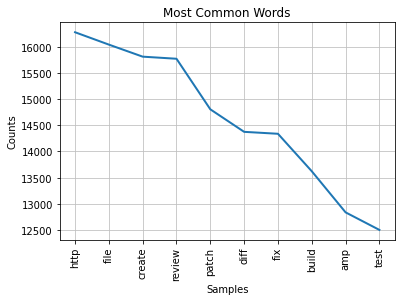

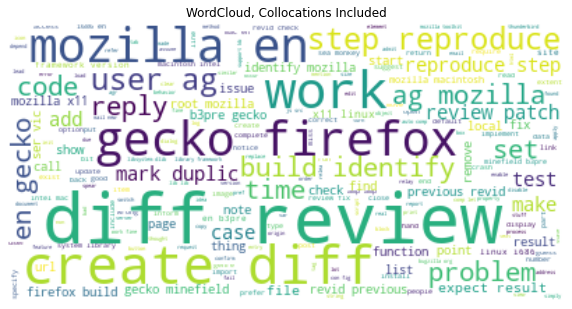

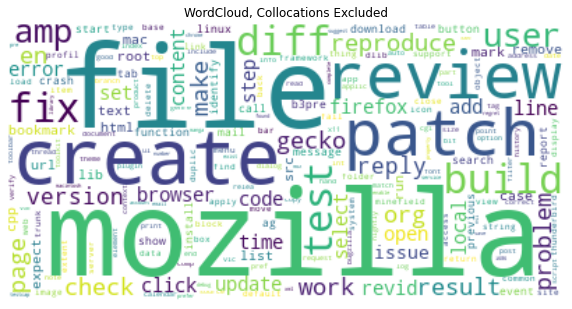

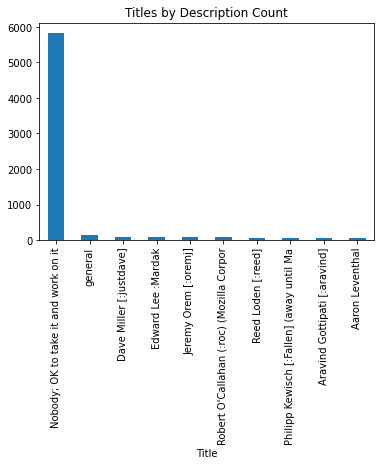

--- Executed in 26.23 seconds ---


In [ ]:
df_titles_agg = brief_summary(df)

**3. Gensim:**

In [ ]:
start_time = time.time()

tokenizer = RegexpTokenizer(r'\w+')
des_list = []
for raw_des in df['spell']:
    token = tokenizer.tokenize(raw_des)
    des_list.append(token)

dictionary = corpora.Dictionary(des_list)
dictionary.filter_extremes(keep_n = 1000) # keep top 1000 terms
doc_term_matrix = [dictionary.doc2bow(token) for token in des_list]

gensim_matrix = pd.DataFrame(0, index = range(len(dictionary)),
                         columns = range(len(doc_term_matrix)))
gensim_matrix['term'] = pd.Series(dictionary).values
for i in range(len(doc_term_matrix)):
    for coordinate in doc_term_matrix[i]:
        result = list(coordinate)
        gensim_matrix.at[result[0], i] = result[1]
print('Gensim Document - Term Matrix:')
print(gensim_matrix)

print('--- Executed in %.5s seconds ---' % (time.time() - start_time))

Gensim Document - Term Matrix:
     0  1  2  3  4  5  6  ...  10293  10294  10295  10296  10297  10298        term
0    1  0  1  0  0  0  0  ...      0      0      0      0      0      0           2
1    1  3  0  0  0  2  1  ...      0      0      0      0      8      0         add
2    3  0  0  0  0  0  0  ...      0      0      0      0      0      0     address
3    1  0  1  0  0  0  0  ...      1      0      0      0      0      1          ag
4    1  0  0  0  0  0  0  ...      4      0      0      2      0      0        auto
..  .. .. .. .. .. .. ..  ...    ...    ...    ...    ...    ...    ...         ...
995  0  0  0  0  0  0  0  ...      0      0      0      0      0      0       video
996  0  0  0  0  0  0  0  ...      0      0      0      0      0      0      vertic
997  0  0  0  0  0  0  0  ...      0      0      0      0      0      0     trouble
998  0  0  0  0  0  0  0  ...      0      0      0      0      0      0       allow
999  0  0  0  0  0  0  0  ...      0      0  

num_topics = 10 -> coherence = 0.38161962346582035
num_topics = 20 -> coherence = 0.3522935130371161
num_topics = 30 -> coherence = 0.33191702226774716
num_topics = 40 -> coherence = 0.3230379959157261
num_topics = 50 -> coherence = 0.3116004078023721
num_topics = 60 -> coherence = 0.30011201221762196
num_topics = 70 -> coherence = 0.30363690780797437
num_topics = 80 -> coherence = 0.29174656571148194
num_topics = 90 -> coherence = 0.28741544854847206


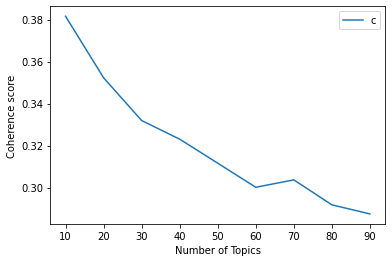

Best num_topic: 10 with coherence =  0.38161962346582035
--- Executed in 596.5 seconds ---


In [ ]:
start_time = time.time()
coherence_values = []
coherence_best = 0
best_nt = 0
x = range(10, 100, 10)
for num_topics in x:
    model = LsiModel(doc_term_matrix, num_topics, id2word = dictionary)
    coherencemodel = CoherenceModel(model = model, texts = des_list,
                                    dictionary = dictionary, coherence = 'c_v')
    result = coherencemodel.get_coherence()
    print('num_topics =', num_topics, '-> coherence =', result)
    if result > coherence_best: coherence_best, best_nt = result, num_topics
    coherence_values.append(result)
plt.plot(x, coherence_values)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc = 'best')
plt.show()
print('Best num_topic:', best_nt, 'with coherence = ', coherence_best)
print('--- Executed in %.5s seconds ---' % (time.time() - start_time))

In [ ]:
# generate LSI model with num_topics = best_nt
start_time = time.time()
lsimodel = LsiModel(doc_term_matrix, num_topics = best_nt, id2word = dictionary)
result = lsimodel.print_topics(num_topics = best_nt, num_words = 7)
for i in range(best_nt):
    print('Topic', i + 1, end = '')
    print(':', end = ' ')
    topic = list(result[i])[1].split(sep = '"')
    for i in range(1, 14, 2): print(topic[i], end = ' ')
    print()
print('--- Executed in %.5s seconds ---' % (time.time() - start_time))

Topic 1: lib file version patch test review amp 
Topic 2: lib a version system library apply patch 
Topic 3: lib version a apply system library r 
Topic 4: file nam product all date program install 
Topic 5: browser png revid amp win root icon 
Topic 6: http cpp amp revid url test line 
Topic 7: folder mail amp l10n cpp http block 
Topic 8: l10n amp http mail patch extensions review 
Topic 9: test l10n folder info service fail patch 
Topic 10: info symbol table service amp update debug 
--- Executed in 0.950 seconds ---


**4. Sklearn:**

In [ ]:
start_time = time.time()
tokenized_des = df['spell'].apply(lambda x: x.split())
# de-tokenization
detokenized_des = []
for i in range(len(tokenized_des)):
    t = ' '.join(tokenized_des[i])
    detokenized_des.append(t)

vectorizer = CountVectorizer(max_features = 1000) # keep top 1000 terms
X = vectorizer.fit_transform(detokenized_des)
dictionary = vectorizer.get_feature_names()
sklearn_matrix = pd.DataFrame(X.T.todense())
sklearn_matrix['term'] = pd.Series(dictionary).values
print('Sklearn Document - Term Matrix:')
print(sklearn_matrix)

vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 1000,
                             smooth_idf = True)
X = vectorizer.fit_transform(detokenized_des)
sklearn_tfidf = pd.DataFrame(X.T.todense())
sklearn_tfidf['term'] = sklearn_matrix['term']
print('Sklearn TF-IDF Matrix:')
print(sklearn_tfidf)

svd_model = TruncatedSVD(n_components = best_nt, algorithm = 'randomized',
                         n_iter = 100, random_state = 122)
svd_model.fit(X)
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key = lambda x:x[1],
                          reverse = True)[:7]
    print('Topic ' + str(i + 1) + ':', end = '')
    for t in sorted_terms:
        print('', t[0], end = '')
    print('.')
print('--- Executed in %.5s seconds ---' % (time.time() - start_time))

Sklearn Document - Term Matrix:
     0  1  2  3  4  5  6  ...  10293  10294  10295  10296  10297  10298        term
0    0  0  0  0  0  0  0  ...      0      0      0      0      0      0    20071127
1    0  0  0  0  0  0  0  ...      0      0      0      0      0      0  2007121120
2    0  0  0  0  0  0  0  ...      0      0      0      0      0      0        _ver
3    0  0  0  0  0  0  0  ...      0      0      0      0      0      0        a1pr
4    0  0  0  0  0  0  0  ...      0      0      0      0      0      0      accept
..  .. .. .. .. .. .. ..  ...    ...    ...    ...    ...    ...    ...         ...
995  0  0  0  0  0  0  0  ...      0      0      0      0      0      0       yahoo
996  0  0  0  0  0  0  0  ...      1      0      0      0      0      0        yeah
997  0  0  0  0  0  0  0  ...      0      0      0      0      0      0        year
998  0  0  0  0  0  0  0  ...      0      0      0      0      0      0         zip
999  0  0  0  0  0  0  0  ...      0      0 

**5. Query Retrieval : Accuracy - Precision - Recall**

In [ ]:
start_time = time.time()
# Split Dataset to Training & Testing Subsets
df_fair = df[df.Title.isin(df_titles_agg[0:11])]
df_train, df_test = train_test_split(df_fair[['Title', 'spell']], test_size = 0.20)
df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

# Building Classifier
tokenized_des = df_train['spell'].apply(lambda x: x.split())
detokenized_des = []
for i in range(len(tokenized_des)):
    t = ' '.join(tokenized_des[i])
    detokenized_des.append(t)
vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 1000,
                             smooth_idf = True)
X = vectorizer.fit_transform(detokenized_des)
svd_model = TruncatedSVD(n_components = best_nt, algorithm = 'randomized',
                         n_iter = 100, random_state = 122)
test_matrix = svd_model.fit_transform(X)

# Predicting
df_test['predict'] = ''
for i in range(len(df_test)):
    sample = df_test.at[i, 'spell']
    sample_vector = vectorizer.transform([sample])
    sample_matrix = svd_model.transform(sample_vector)
    distance = cosine_similarity(sample_matrix, test_matrix).flatten()
    index = np.argwhere(distance == np.amax(distance))
    df_test.at[i, 'predict'] = df_train.at[index[0][0], 'Title']

# Display Accuracy, Precision & Error
print(confusion_matrix(df_test['Title'], df_test['predict']))
print(classification_report(df_test['Title'], df_test['predict']))
print('--- Executed in %.5s seconds ---' % (time.time() - start_time))

[[   1    0    0    1    0    0   14    0    0    2    0]
 [   0    2    0    0    0    2    8    0    0    0    0]
 [   0    0    2    0    0    4    8    0    0    0    0]
 [   0    0    0    4    1    0    8    0    0    0    0]
 [   0    0    0    0    6    0    6    0    0    1    0]
 [   0    2    0    0    0    3    7    0    3    0    0]
 [   7    9    7    8    9   10 1077    5    4    8   31]
 [   0    0    0    0    0    0    5    4    0    0    0]
 [   0    0    0    0    0    0    4    0    3    1    0]
 [   1    0    1    0    0    0    9    0    0    4    1]
 [   0    0    0    0    0    0   22    0    0    1    2]]
                                          precision    recall  f1-score   support

                         Aaron Leventhal       0.11      0.06      0.07        18
            Aravind Gottipati [:aravind]       0.15      0.17      0.16        12
                 Dave Miller [:justdave]       0.20      0.14      0.17        14
                 Dave Townsend (